In [9]:
'''
robust versions of logistic regression
support vector machines
random forests
gradient boosted decision trees (XGBoost) <--
neural networks

https://www.kdnuggets.com/2020/06/simplifying-mixed-feature-type-preprocessing-scikit-learn-pipelines.html
https://www.kaggle.com/kritidoneria/explainable-ai-eli5-lime-and-shap
https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Diabetes%20regression.html
https://kiwidamien.github.io/introducing-the-column-transformer.html
https://medium.com/analytics-vidhya/shap-part-2-kernel-shap-3c11e7a971b1
'''

import os, sys
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GridSearchCV 
import joblib
sns.set(color_codes=True)
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [2]:
path = "/home/nacho/Documents/coronavirus/COVID-19_Paper/"
os.chdir(os.path.join(path)) 

In [3]:
#%%Valida si existen las carpetas
try:
    os.makedirs("plots")
    os.makedirs("models")
except FileExistsError:
    pass

In [3]:
#%%gridsearchcv
#checar stratify
#checar tipo de scoring
#sklearn.metrics.SCORERS.keys()
def gridsearchcv(X_train, X_test, y_train, y_test):
    ############
    # Scale numeric values
    num_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler())])
        #('scaler', StandardScaler())])
    
    preprocessor = ColumnTransformer(
        remainder='passthrough',
        transformers=[
            ('num', num_transformer, make_column_selector(pattern='EDAD'))
            ])
    ############
    
    pipe_steps = [
        #('scaler', StandardScaler()),
        ('preprocessor', preprocessor),
        ('SupVM', SVC(kernel='rbf',probability=True)) #agregar kernel linear
        ]
    
    param_grid= {
        'SupVM__C': [0.1, 0.5, 1, 10, 30, 40, 50, 75, 100, 250, 500, 750, 1000], 
        'SupVM__gamma' : [0.0001, 0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 50, 75, 100]
        }
    
    pipeline = Pipeline(pipe_steps)
    grid = GridSearchCV(pipeline, param_grid,refit = True,cv = 5, verbose = 3, n_jobs=-1,scoring='balanced_accuracy')#'f1'
    grid.fit(X_train, y_train)
    print("Best-Fit Parameters From Training Data:\n",grid.best_params_)
    grid_predictions = grid.best_estimator_.predict(X_test) 
    report = classification_report(y_test, grid_predictions, output_dict=True)
    report = pd.DataFrame(report).transpose()
    print(report)
    print(confusion_matrix(y_test, grid_predictions))
    return grid, report

In [4]:
#%%CASO 1: prediccion de hospitalizacion por covid
hosp_data = pd.read_csv("prediction_data/df_caso1.zip")
#Porcentaje de informacion del dataset
hosp_data = hosp_data.sample(frac=0.001)

#separar datos
X = hosp_data.loc[:, hosp_data.columns != 'TIPO_PACIENTE']
y = hosp_data.loc[:,'TIPO_PACIENTE']
print(y.value_counts())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify=y, shuffle=True)

0    1448
1     348
Name: TIPO_PACIENTE, dtype: int64


In [10]:
#%%Entrenamiento (opcional)
#---->train
grid, grid_report= gridsearchcv(X_train, X_test, y_train, y_test)
#guarda el modelo y su reporte
joblib.dump(grid, 'models/hosp_data_grid.pkl', compress = 1)
grid_report.to_csv("models/hosp_data_grid_report.csv", index=True)
'''
Best-Fit Parameters From Training Data:
 {'SupVM__C': 500, 'SupVM__gamma': 1}
              precision    recall  f1-score    support
0              0.845872  0.964435  0.901271  478.00000
1              0.645833  0.269565  0.380368  115.00000
accuracy       0.829680  0.829680  0.829680    0.82968
macro avg      0.745852  0.617000  0.640819  593.00000
weighted avg   0.807078  0.829680  0.800253  593.00000
[[461  17]
 [ 84  31]]
'''

Fitting 5 folds for each of 154 candidates, totalling 770 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 770 out of 770 | elapsed:  3.2min finished
Best-Fit Parameters From Training Data:
 {'SupVM__C': 75, 'SupVM__gamma': 5}
              precision    recall  f1-score     support
0              0.828897  0.923729  0.873747  472.000000
1              0.462687  0.256198  0.329787  121.000000
accuracy       0.787521  0.787521  0.787521    0.787521
macro avg      0.645792  0.589964  0.601767  593.000000
weighted avg   0.754173  0.787521  0.762754  593.000000
[[436  36]
 [ 90  31]]


"\nBest-Fit Parameters From Training Data:\n {'SupVM__C': 500, 'SupVM__gamma': 1}\n              precision    recall  f1-score    support\n0              0.845872  0.964435  0.901271  478.00000\n1              0.645833  0.269565  0.380368  115.00000\naccuracy       0.829680  0.829680  0.829680    0.82968\nmacro avg      0.745852  0.617000  0.640819  593.00000\nweighted avg   0.807078  0.829680  0.800253  593.00000\n[[461  17]\n [ 84  31]]\n"

In [5]:
#%%importa el modelo y su rendimiento
grid = joblib.load('models/hosp_data_grid.pkl')
grid_report = pd.read_csv("models/hosp_data_grid_report.csv", index_col=0)
print("best score from grid search: %f" % grid.best_estimator_.score(X_test, y_test))
df_grid = pd.DataFrame(grid.cv_results_)

best score from grid search: 0.802698


In [6]:
#metodos y atributos del objeto grid
dir(grid)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_check_is_fitted',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_pairwise',
 '_required_parameters',
 '_run_search',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'get_params',
 'iid',
 'inverse_transform',
 'multimetric_',
 'n_jobs',
 'n_splits_',
 'param_grid',
 'pre_dispatch',
 'predict',
 'predict_log_proba',

In [7]:
df_grid[['param_SupVM__C', 'param_SupVM__gamma','mean_test_score']].sort_values(by = ['mean_test_score'], ascending=False)

,param_SupVM__C,param_SupVM__gamma,mean_test_score
107,75,5,0.632664
135,500,5,0.631569
121,100,5,0.630102
108,75,10,0.630049
53,10,50,0.629656
...,...,...,...
70,40,0.0001,0.500000
10,0.1,10,0.500000
0,0.1,0.0001,0.500000
11,0.1,50,0.499479


In [14]:
#%%Pipeline without gridsearchcv

num_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

preprocessor = ColumnTransformer(
    remainder='passthrough',
    transformers=[
        ('num', num_transformer, ['EDAD'])])

svc_model = Pipeline([
    #('scaler', StandardScaler()),
    ('preprocessor', preprocessor),
    ('SupVM', SVC(kernel='rbf',probability=True))])

#svc_model.set_params(**grid.best_params_)
svc_model.set_params(**{'SupVM__C': 500, 'SupVM__gamma': 1})
#print("Model params: ",svc_model.get_params("model"))

svc_model.fit(X_train, y_train)
y_pred = svc_model.predict(X_test)
metrics.accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

model_score = cross_val_score(svc_model, X_train, y_train, cv=StratifiedKFold(n_splits=5))
print("5 split scores:" ,model_score)
print("Mean of the 5 split scores:" ,model_score.mean())

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       478
           1       0.48      0.28      0.35       115

    accuracy                           0.80       593
   macro avg       0.66      0.60      0.62       593
weighted avg       0.77      0.80      0.78       593

5 split scores: [0.8340249  0.81327801 0.80912863 0.825      0.82916667]
Mean of the 5 split scores: 0.8221196403872753


In [15]:
#%%se preprocesan los datos
X_train_scaled = pd.DataFrame(svc_model.named_steps['preprocessor'].fit_transform(X_train),columns = X_train.columns)
X_test_scaled = pd.DataFrame(svc_model.named_steps['preprocessor'].fit_transform(X_test),columns = X_test.columns)
#cambia el orden de edad y sexo
X_train_scaled[['EDAD','SEXO']]=X_train_scaled[['SEXO','EDAD']]
X_test_scaled[['EDAD','SEXO']]=X_test_scaled[['SEXO','EDAD']]

In [18]:
y_test.iloc[20] 

1

In [17]:
X_test.iloc[20]

SEXO               0
EDAD              26
EMBARAZO           0
DIABETES           0
EPOC               0
ASMA               0
INMUSUPR           0
HIPERTENSION       0
CARDIOVASCULAR     0
OBESIDAD           0
RENAL_CRONICA      0
TABAQUISMO         0
Name: 932525, dtype: int64

In [19]:
#%%#prueba el modelo con X_test
svc_model.named_steps['SupVM'].predict(X_test_scaled.iloc[20, :].values.reshape(1, -1))

array([0])

In [20]:
svc_model.named_steps['SupVM'].predict_proba(X_test_scaled.iloc[20, :].values.reshape(1, -1))

array([[0.91288434, 0.08711566]])

In [21]:
import shap
# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(model = svc_model.named_steps['SupVM'].predict_proba, data = X_train_scaled, link = 'logit')
shap_values = explainer.shap_values(X = X_test_scaled, nsamples = 30, l1_reg="num_features(12)")

Using 1203 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 593/593 [20:32<00:00,  2.08s/it]


In [22]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 2
Shape of each element: (593, 12)


In [23]:
#prediction and probability of model
print(f'Prediction for 1st sample in X_test: ', svc_model.named_steps['SupVM'].predict(X_test_scaled.iloc[[0], :])[0])
print(f'Prediction probability for 1st sample in X_test: ', svc_model.named_steps['SupVM'].predict_proba(X_test_scaled.iloc[[0], :])[0])

Prediction for 1st sample in X_test:  0
Prediction probability for 1st sample in X_test:  [0.91075977 0.08924023]


In [24]:
# plot the SHAP values for the false (0) output of the first instance
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test_scaled.iloc[0,:], link="logit")

In [25]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test_scaled.iloc[0,:], link="logit")

In [26]:
#Explaining the Prediction for all samples in Test set
#no hospitalizado
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test_scaled)

In [27]:
#si hospitalizado
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test_scaled)

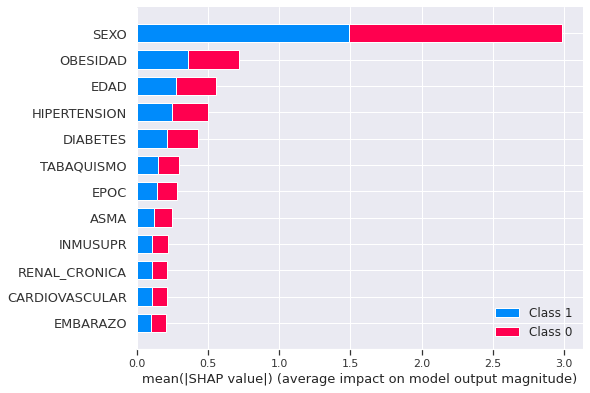

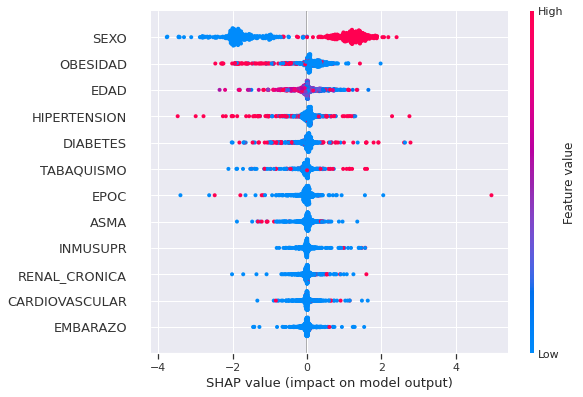

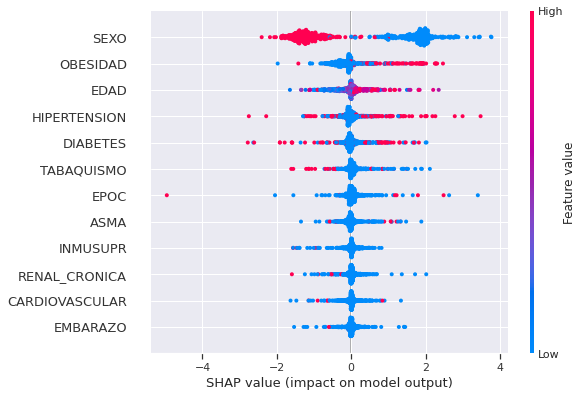

In [28]:
#SHAP Summary Plots
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values[1], X_test_scaled)
shap.summary_plot(shap_values[0], X_test_scaled)

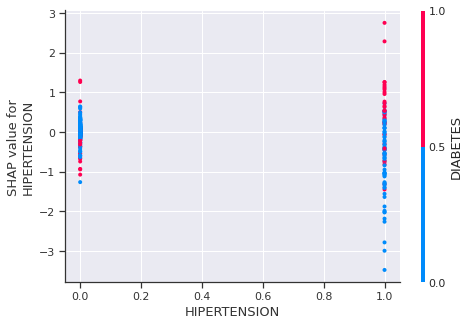

In [29]:
#SHAP Dependence Plots
shap.dependence_plot("HIPERTENSION", shap_values[1], X_test_scaled)